In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [2]:
!nvidia-smi

Sat May 11 08:44:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

2024-05-11 08:44:46.482403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 08:44:46.482497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 08:44:46.585448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [6]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [7]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

### Load data

Link: https://huggingface.co/datasets/samsum

In [8]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


# Evaluating PEGASUS on SAMSum

In [9]:
dataset_samsum['test'][0]['dialogue']

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [10]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [11]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [12]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)

/tmp/ipykernel_34/3997016631.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(



100%|██████████| 103/103 [18:04<00:00, 10.53s/it]


In [13]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015554,0.000297,0.015541,0.01553


# Histogram

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


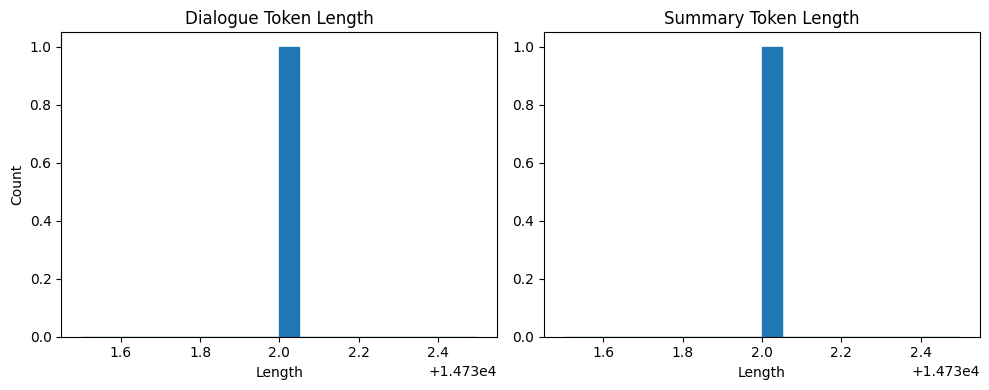

In [14]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [15]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3935: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [16]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [17]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.7 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.3
    Uninstalling accelerate-0.29.3:
      Successfully uninstalled accelerate-0.29.3


In [18]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(report_to="none",
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [19]:

trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  deprecated_dl_args["split_batches"] = split_batches


In [20]:
trainer.train()


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


TrainOutput(global_step=460, training_loss=2.004107477353967, metrics={'train_runtime': 4734.9866, 'train_samples_per_second': 3.111, 'train_steps_per_second': 0.097, 'total_flos': 7673700761518080.0, 'train_loss': 2.004107477353967, 'epoch': 1.0})

In [21]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )


100%|██████████| 410/410 [12:15<00:00,  1.79s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.01857,0.000296,0.018431,0.018448


In [22]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


In [23]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Test

In [ ]:
dataset_samsum = load_dataset("samsum")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [26]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

In [27]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:

Hannah: Hey, do you have Betty's number?

Amanda: Lemme check

Hannah: <file_gif>

Amanda: Sorry, can't find it.

Amanda: Ask Larry

Amanda: He called her last time we were at the park together

Hannah: I don't know him well

Hannah: <file_gif>

Amanda: Don't be shy, he's very nice

Hannah: If you say so..

Hannah: I'd rather you texted him

Amanda: Just text him 🙂

Hannah: Urgh.. Alright

Hannah: Bye

Amanda: Bye bye



Reference Summary:

Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.



Model Summary:

Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [27]:
import pandas as pd

# Define the data for the original and fine-tuned models
data = {
    "Model": ["Original Pegasus", "Fine-tuned Pegasus"],
    "rouge1": [0.015554, 0.01857],
    "rouge2": [0.000297, 0.000296],
    "rougeL": [0.015541, 0.018431],
    "rougeLsum": [0.01553, 0.018448]
}

# Create a dataframe from the data dictionary
df = pd.DataFrame(data)

# Print the dataframe
df

,Model,rouge1,rouge2,rougeL,rougeLsum
0,Original Pegasus,0.015554,0.000297,0.015541,0.015530
1,Fine-tuned Pegasus,0.018570,0.000296,0.018431,0.018448


In [30]:
import shutil
import os
import zipfile

# Define the directories to be zipped
directories_to_zip = ["/kaggle/working/pegasus-samsum-model", "/kaggle/working/tokenizer"]

# Define the filenames for the zip files
zip_filenames = ["pegasus-samsum-model.zip", "tokenizer.zip"]

# Create zip files for each directory
for directory, zip_filename in zip(directories_to_zip, zip_filenames):
    shutil.make_archive(zip_filename[:-4], 'zip', directory)

# Download the zip files to local system
for zip_filename in zip_filenames:
    shutil.move(zip_filename, "/kaggle/working/" + zip_filename)

# Optionally, move the zip files to the "/kaggle/working/" directory if not already there
# for zip_filename in zip_filenames:
#     shutil.move(zip_filename, "/kaggle/working/" + zip_filename)

# Print the path of the downloaded zip files
for zip_filename in zip_filenames:
    print("Downloaded zip file:", os.path.join("/kaggle/working/", zip_filename))


Downloaded zip file: /kaggle/working/pegasus-samsum-model.zip
Downloaded zip file: /kaggle/working/tokenizer.zip


In [4]:
!wget -O /kaggle/working/pegasus-samsum-model.zip.extension URL

--2024-05-11 11:29:30--  http://url/
Resolving url (url)... failed: Name or service not known.
wget: unable to resolve host address 'url'
